### Notebook to configure model

In [1]:
import time
import math
import copy
import pickle

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context(context="talk")

import torch
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils import data


/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
isRetrain = False

# Hyperparameter

QUERY_SIZE = 1
EMBEDDING_SIZE = 20

# HIDDEN_SIZE = 512
# ATTENTION_SIZE = 64

LEARNING_RATE = 5*1e-2
BATCH_SIZE = 500

VOCAB_SIZE = 5
NUM_CLASSES = 2

# Data-specific

READ_LENGTH = 10

GENOME_START = 0
GENOME_END = 99


# # KRAS
# GENOME_START = 25204789
# GENOME_END = 25250936

# # NOTCH1
# GENOME_START = 136494433 
# GENOME_END = 136545786

# # NRAS
# GENOME_START = 114704464 
# GENOME_END = 114716894

GENOME_LENGTH = GENOME_END - GENOME_START + 1  
CONTEXT_SIZE = GENOME_LENGTH

ref_names = ["class", "ref", "sequence"]
VOCAB = ['N','A','T','C','G']


In [3]:
def load_ref_data(file_name, sample_ratio= 1, n_class=2, names=ref_names):
    
    csv_file = pd.read_csv(file_name, names=ref_names)
    shuffle_csv = csv_file.sample(frac=sample_ratio).reset_index()
#     x = pd.Series(shuffle_csv["sequence"])
    x = list(shuffle_csv["sequence"])
#     ref = pd.Series(shuffle_csv["ref"])
    ref = list(shuffle_csv["ref"])
    y = pd.Series(shuffle_csv["class"])
    y = to_one_hot(y, n_class)
    print(y.shape)
#     print(type(x))
#     print(type(y))
#     print(type(ref))

    return x, ref, y


In [4]:
def create_synthetic_data(file_name, cancer_genes, benign_genes, cancer_cnv=None, benign_cnv=None, num_patients=10, num_reads_per_patients=3, read_length=READ_LENGTH, genome_length=GENOME_LENGTH, vocab=VOCAB, isSomatic=True, print_seq=False):
    
    seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    backup_seq_list = seq_list
    
    for loc, mutation in cancer_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]        
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)

    if cancer_cnv is not None:
        for cnv, prob in cancer_cnv.items():
            switch = np.random.choice(num_patients*num_reads_per_patients, int(num_patients*num_reads_per_patients*prob))
            locs[switch] = cnv      
    
    file = open('./tumor-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./tumor-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1, %d, %s\n" % (locs[r], reads[r]))
    file.close()
    
    tumor_locs = locs
    tumor_reads = reads

    if isSomatic:
        seq_list = backup_seq_list
    else:
        seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    
    for loc, mutation in benign_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)
    
    if benign_cnv is not None:
        for cnv, prob in benign_cnv.items():
            switch = np.random.choice(num_patients*num_reads_per_patients, int(num_patients*num_reads_per_patients*prob))
            locs[switch] = cnv 
        
    file = open('./normal-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./normal-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("0, %d, %s\n" % (locs[r], reads[r]))
    file.close() 
    
    normal_locs = locs
    normal_reads = reads
    
    file = open('./syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1,%d,%s\n" % (tumor_locs[r], tumor_reads[r]))
        file.write("0,%d,%s\n" % (normal_locs[r], normal_reads[r]))
    file.close() 
    
    return './syn-'+file_name+'.csv'
    


In [5]:
def to_one_hot(y, n_class):
    
    return np.eye(n_class)[y.astype(int)]


In [6]:
def split_ref_dataset(x_test, y_test, ref_test, dev_ratio):

    test_size = len(x_test)
    print(test_size)
    dev_size = (int)(test_size * dev_ratio)
    print(dev_size)

    x_dev = x_test[:dev_size]
    x_test = x_test[dev_size:]
    y_dev = y_test[:dev_size]
    y_test = y_test[dev_size:]
    ref_dev = ref_test[:dev_size]
    ref_test = ref_test[dev_size:]

    return x_test, x_dev, y_test, y_dev, ref_test, ref_dev, dev_size, test_size - dev_size


In [7]:
class TensorizedReadDataset(torch.utils.data.DataLoader):
    'Characterizes a Tensorized dataset for genome reads in PyTorch'
    
    def __init__(self, reads, ref_locs, labels, read_length=100, genome_start=0, genome_end=0):
#         super(TensorizedReadDataset, self).__init__()
        
        self.read_length = read_length
        self.labels = labels
        self.reads = reads
        self.ref_locs = ref_locs
        self.genome_start = genome_start
        self.genome_end = genome_end

    def __len__(self):
        return len(self.reads)

    def __getitem__(self, index):
        
        vals = list(self.reads[index])[0:self.read_length]        
        locs = list(np.arange(self.ref_locs[index]-self.genome_start,self.ref_locs[index]+self.read_length-self.genome_start))

#         print(len(vals))
#         print(len(locs))
        
        vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}
#         read = torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int), requires_grad=False)

        read = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int)), requires_grad=False)
        
        X = read
        Y = self.labels[index,:]

#         torch.LongTensor(self.labels[index,:])

        return X, Y
    

In [8]:
class SequenceAttentionClassifier(nn.Module):
    
    def __init__(self, genome_length, vocab_size=5, query_size=10, embedding_size=128, num_classes=2):
        
        super(SequenceAttentionClassifier, self).__init__()
        
        self.genome_length = genome_length
        self.vocab_size = vocab_size
        self.query_size = query_size
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.K = nn.Embedding(vocab_size*genome_length, embedding_size)
        self.V = nn.Embedding(vocab_size*genome_length, query_size)
        self.W = nn.Linear(query_size, num_classes)
        self.Q = nn.Linear(embedding_size, query_size)
        
    def forward(self, read):
        
        # 'read' here should be mapped to a flattened form where X_ij = 1 maps to i*vocab_size + j
        K_lookup = self.K(read) # Get the relevant keys
        V_lookup = self.V(read) # Get the relevant values

        # Get the attention weights
        logits = self.Q(K_lookup) / math.sqrt(self.embedding_size)
        probs = F.softmax(logits, dim = 0)
        
        # Calculate the covariates for the logistic regression
#         X = torch.matmul(probs.transpose(1,2), V_lookup)
#         X = probs * V_lookup
        X = (probs * V_lookup).sum(dim=1)
#         print(X.shape, probs.shape, V_lookup.shape)

        # Right now we can just ignore the fact that we're doing a linear-transform.
        # In the future we'll add nonlinearities

        # Return the logits for the classifier
        return self.W(X), K_lookup, V_lookup
    

In [9]:
# load data

cancer_genes = {5 :['A',0.95], 
                8 :['G',0.8],
                30:['T',1],
                31:['G',1],
                50:['A',0.6],
                55:['G',0.7],
                60:['G',1],
                70:['C',0.85],
                90:['C',1],
                95:['N',1]}
benign_genes = {10:['C',0.99],
                11:['G',0.98],
                12:['T',1],
                53:['A',0.9],
                80:['G',0.85]}

num_patients = 1000
num_reads_per_patients = 50
read_length = 95
file_name = 'p1000-t50-r95-somatic-Q1'

syn_file = create_synthetic_data(file_name, cancer_genes, benign_genes, None, None, num_patients, num_reads_per_patients, read_length, isSomatic=True)
print(syn_file)

x_train, refs_train, y_train = load_ref_data(syn_file, sample_ratio=1)


# split dataset to test and dev
x_train, x_test, y_train, y_test, refs_train, refs_test, test_size, train_size = \
    split_ref_dataset(x_train, y_train, refs_train, 0.2)
    
# split dataset to test and dev
x_test, x_val, y_test, y_val, refs_test, refs_val, val_size, test_size = \
    split_ref_dataset(x_test, y_test, refs_test, 0.5)
    
print("Test size: ", test_size)
print("Validation size: ", val_size)
print("Training size: ", train_size)


./syn-p1000-t50-r95-somatic-Q1.csv
(100000, 2)
100000
20000
20000
10000
Test size:  10000
Validation size:  10000
Training size:  80000


In [10]:
## Generators
train_dataset = TensorizedReadDataset(reads=x_train, 
                                      ref_locs=refs_train, 
                                      labels=y_train, 
                                      read_length=READ_LENGTH, 
                                      genome_start=GENOME_START, 
                                      genome_end=GENOME_END)

val_dataset = TensorizedReadDataset(reads=x_val, 
                                        ref_locs=refs_val, 
                                        labels=y_val, 
                                        read_length=READ_LENGTH, 
                                        genome_start=GENOME_START, 
                                        genome_end=GENOME_END)

test_dataset = TensorizedReadDataset(reads=x_test, 
                                        ref_locs=refs_test, 
                                        labels=y_test, 
                                        read_length=READ_LENGTH, 
                                        genome_start=GENOME_START, 
                                        genome_end=GENOME_END)


# Input pipeline
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)


In [14]:
isRetrain = True
file_name = 'p1000-t50-r95-somatic-Q1'


In [15]:
model = SequenceAttentionClassifier(genome_length=GENOME_LENGTH,
                                    vocab_size=VOCAB_SIZE,
                                    query_size=QUERY_SIZE,
                                    embedding_size=EMBEDDING_SIZE,
                                    num_classes=NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# if isRetrain:
#     model.load_state_dict(torch.load('./dummy_'+file_name+'_model.pth'))
#     model = torch.load('./full_dummy_'+file_name+'_model.pt')

In [17]:
num_epochs = 50

acc_each_epoch = []

loss_each_batch = []
loss_val_each_batch = []

acc_each_batch = []


# Training process
for epoch in range(num_epochs):
    b = 0 # count batch
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        outputs, K, V = model(x_batch) 
        
        lam = 1e-4
        
#         loss = criterion(outputs, y_batch) 
        data_loss = criterion(outputs, torch.max(y_batch.type(torch.LongTensor), 1)[1])
        reg_loss = (torch.norm(K,2,1).mean() + torch.norm(V,2,1).mean())*lam
        loss = data_loss + reg_loss
    
        loss.backward()
        optimizer.step()
        
        if (b + 1) % 10 == 0:
            print("Epoch {}, Batch {}, loss :{}".format(epoch + 1, b + 1, loss))
        b = b + 1
        
        loss_each_batch.append(data_loss)
        
        correct = 0
        total = 0
        for x_batch, y_batch in val_loader:
            
            outputs, K, V = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, torch.max(y_batch.type(torch.LongTensor), 1)[1])
            loss_val_each_batch.append(loss)
            
            total += y_batch.size(0)
            correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()
        
        acc = int(correct) / total
#         print(total, int(correct), acc)
        print('Validation Accuracy: {}%'.format(100 * acc))   
        acc_each_batch.append(acc)
    
    correct = 0
    total = 0
    for x_batch, y_batch in val_loader:
        outputs, K, V = model(x_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()
    acc = int(correct) / total
    print('Validation Accuracy: {}%'.format(100 * acc))   
    acc_each_epoch.append(acc)

            

Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Epoch 1, Batch 10, loss :0.7003467082977295
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%
Validation Accuracy: 49.68%


KeyboardInterrupt: 

In [ ]:
torch.save(model, './full_dummy_'+file_name+'_lambda1em4_model.pt')
torch.save(model.state_dict(), './dummy_'+file_name+'_lambda1em4_model.pth')

acc_each_epoch_lambda1em4 = acc_each_epoch 
loss_each_batch_lambda1em4 = loss_each_batch
loss_val_each_batch_lambda1em4 = loss_val_each_batch
acc_each_batch_lambda1em4 = acc_each_batch

pickle.dump( [acc_each_epoch, loss_each_batch, loss_val_each_batch, acc_each_batch], open('./acc_'+file_name+'_lambda1em4.pkl', 'wb') )

In [18]:
model_lr1em1lm1em2 = model
model_lr1em1lm1em3 = model
model_lr1em1lm1em4 = model
model_lr1em1lm1em5 = model
model_lr5em2lm1em2 = model
model_lr5em2lm1em3 = model
model_lr5em2lm1em4 = model
model_lr5em2lm1em5 = model

model_lr1em1lm1em2 = torch.load('./attention/full_dummy_'+file_name+'_lr1em1lm1em2_model.pt')
model_lr1em1lm1em3 = torch.load('./attention/full_dummy_'+file_name+'_lr1em1lm1em2_model.pt')
model_lr1em1lm1em4 = torch.load('./attention/full_dummy_'+file_name+'_lr1em1lm1em2_model.pt')
model_lr1em1lm1em5 = torch.load('./attention/full_dummy_'+file_name+'_lr1em1lm1em2_model.pt')
model_lr5em2lm1em2 = torch.load('./attention/full_dummy_'+file_name+'_lr5em2lm1em2_model.pt')
model_lr5em2lm1em3 = torch.load('./attention/full_dummy_'+file_name+'_lr5em2lm1em2_model.pt')
model_lr5em2lm1em4 = torch.load('./attention/full_dummy_'+file_name+'_lr5em2lm1em2_model.pt')
model_lr5em2lm1em5 = torch.load('./attention/full_dummy_'+file_name+'_lr5em2lm1em2_model.pt')


/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type Se

In [31]:
acc_each_epoch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr1em1lm1em2.txt')])
loss_each_batch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr1em1lm1em2.txt')])
loss_val_each_batch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr1em1lm1em2.txt')])
acc_each_batch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr1em1lm1em2.txt')])


acc_each_batch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr1em1lm1em2.txt')])
acc_each_batch_lr1em1lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr1em1lm1em3.txt')])
acc_each_batch_lr1em1lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr1em1lm1em4.txt')])
acc_each_batch_lr1em1lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr1em1lm1em5.txt')])
acc_each_batch_lr5em2lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr5em2lm1em2.txt')])
acc_each_batch_lr5em2lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr5em2lm1em3.txt')])
acc_each_batch_lr5em2lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr5em2lm1em4.txt')])
acc_each_batch_lr5em2lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_batch_lr5em2lm1em5.txt')])

acc_each_epoch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr1em1lm1em2.txt')])
acc_each_epoch_lr1em1lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr1em1lm1em3.txt')])
acc_each_epoch_lr1em1lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr1em1lm1em4.txt')])
acc_each_epoch_lr1em1lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr1em1lm1em5.txt')])
acc_each_epoch_lr5em2lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr5em2lm1em2.txt')])
acc_each_epoch_lr5em2lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr5em2lm1em3.txt')])
acc_each_epoch_lr5em2lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr5em2lm1em4.txt')])
acc_each_epoch_lr5em2lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_acc_each_epoch_lr5em2lm1em5.txt')])

loss_each_batch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr1em1lm1em2.txt')])
loss_each_batch_lr1em1lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr1em1lm1em3.txt')])
loss_each_batch_lr1em1lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr1em1lm1em4.txt')])
loss_each_batch_lr1em1lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr1em1lm1em5.txt')])
loss_each_batch_lr5em2lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr5em2lm1em2.txt')])
loss_each_batch_lr5em2lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr5em2lm1em3.txt')])
loss_each_batch_lr5em2lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr5em2lm1em4.txt')])
loss_each_batch_lr5em2lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_each_batch_lr5em2lm1em5.txt')])

loss_val_each_batch_lr1em1lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr1em1lm1em2.txt')])
loss_val_each_batch_lr1em1lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr1em1lm1em3.txt')])
loss_val_each_batch_lr1em1lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr1em1lm1em4.txt')])
loss_val_each_batch_lr1em1lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr1em1lm1em5.txt')])
loss_val_each_batch_lr5em2lm1em2 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr5em2lm1em2.txt')])
loss_val_each_batch_lr5em2lm1em3 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr5em2lm1em3.txt')])
loss_val_each_batch_lr5em2lm1em4 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr5em2lm1em4.txt')])
loss_val_each_batch_lr5em2lm1em5 = np.asarray([line.rstrip('\n') for line in open('./attention/cv_loss_val_each_batch_lr5em2lm1em5.txt')])

# acc_each_epoch = acc_each_epoch_lr1em1lm1em2 
# loss_each_batch = loss_each_batch_lr1em1lm1em2
# loss_val_each_batch = loss_val_each_batch_lr1em1lm1em2 
# acc_each_batch = acc_each_batch_lr1em1lm1em2 

print('train_loss shape: ', loss_each_batch_lr1em1lm1em2.shape)
print('train_loss shape: ', loss_each_batch_lr1em1lm1em3.shape)
print('train_loss shape: ', loss_each_batch_lr1em1lm1em4.shape)
print('train_loss shape: ', loss_each_batch_lr1em1lm1em5.shape)
print('train_loss shape: ', loss_each_batch_lr5em2lm1em2.shape)
print('train_loss shape: ', loss_each_batch_lr5em2lm1em3.shape)
print('train_loss shape: ', loss_each_batch_lr5em2lm1em4.shape)
print('train_loss shape: ', loss_each_batch_lr5em2lm1em5.shape)

print('val_loss shape: ', loss_val_each_batch_lr1em1lm1em2.shape)
print('val_loss shape: ', loss_val_each_batch_lr1em1lm1em3.shape)
print('val_loss shape: ', loss_val_each_batch_lr1em1lm1em4.shape)
print('val_loss shape: ', loss_val_each_batch_lr1em1lm1em5.shape)
print('val_loss shape: ', loss_val_each_batch_lr5em2lm1em2.shape)
print('val_loss shape: ', loss_val_each_batch_lr5em2lm1em3.shape)
print('val_loss shape: ', loss_val_each_batch_lr5em2lm1em4.shape)
print('val_loss shape: ', loss_val_each_batch_lr5em2lm1em5.shape)

print('acc_batch shape: ', acc_each_batch_lr1em1lm1em2.shape)
print('acc_batch shape: ', acc_each_batch_lr1em1lm1em3.shape)
print('acc_batch shape: ', acc_each_batch_lr1em1lm1em4.shape)
print('acc_batch shape: ', acc_each_batch_lr1em1lm1em5.shape)
print('acc_batch shape: ', acc_each_batch_lr5em2lm1em2.shape)
print('acc_batch shape: ', acc_each_batch_lr5em2lm1em3.shape)
print('acc_batch shape: ', acc_each_batch_lr5em2lm1em4.shape)
print('acc_batch shape: ', acc_each_batch_lr5em2lm1em5.shape)

print('acc_epoch shape: ', acc_each_epoch_lr1em1lm1em2.shape)
print('acc_epoch shape: ', acc_each_epoch_lr1em1lm1em3.shape)
print('acc_epoch shape: ', acc_each_epoch_lr1em1lm1em4.shape)
print('acc_epoch shape: ', acc_each_epoch_lr1em1lm1em5.shape)
print('acc_epoch shape: ', acc_each_epoch_lr5em2lm1em2.shape)
print('acc_epoch shape: ', acc_each_epoch_lr5em2lm1em3.shape)
print('acc_epoch shape: ', acc_each_epoch_lr5em2lm1em4.shape)
print('acc_epoch shape: ', acc_each_epoch_lr5em2lm1em5.shape)



In [32]:
# [acc_each_epoch, loss_each_batch, loss_val_each_batch, acc_each_batch] = pickle.load(open('./acc_'+file_name+'_lambda1em4.pkl', 'rb'))

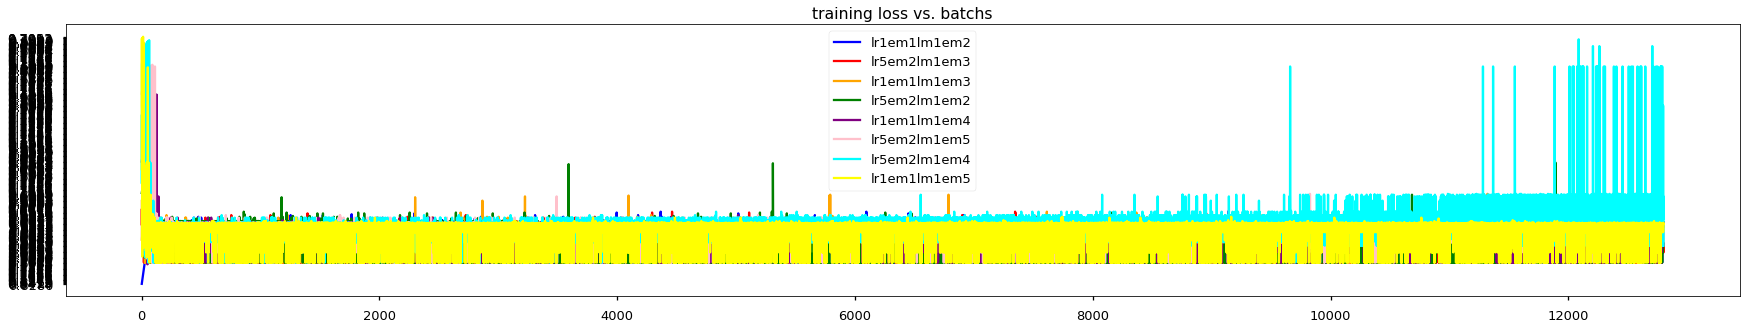

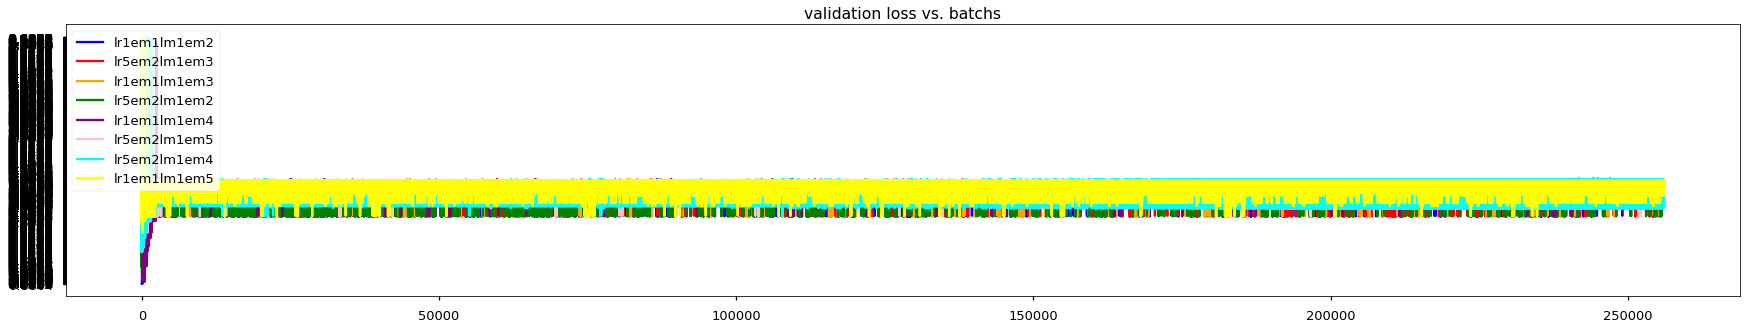

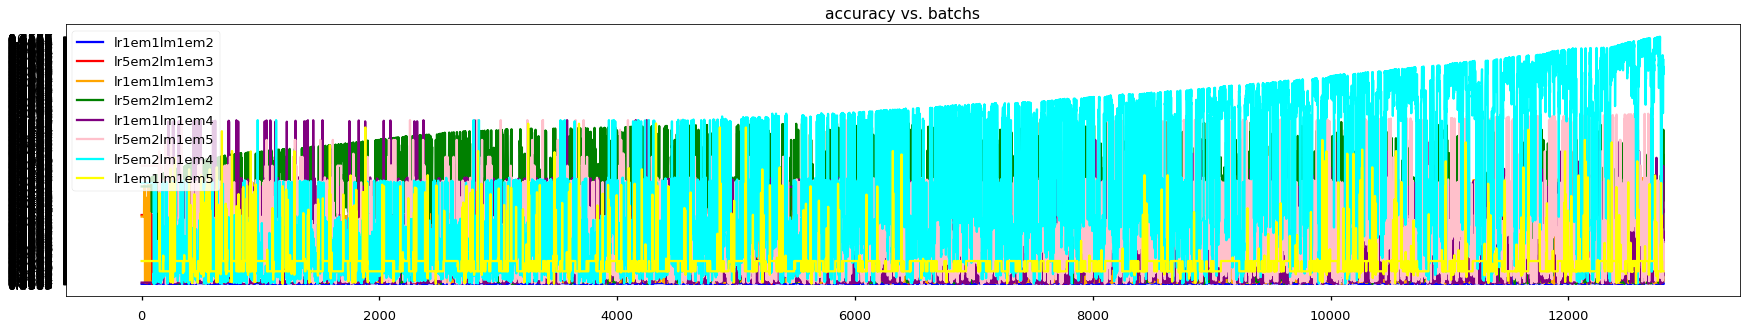

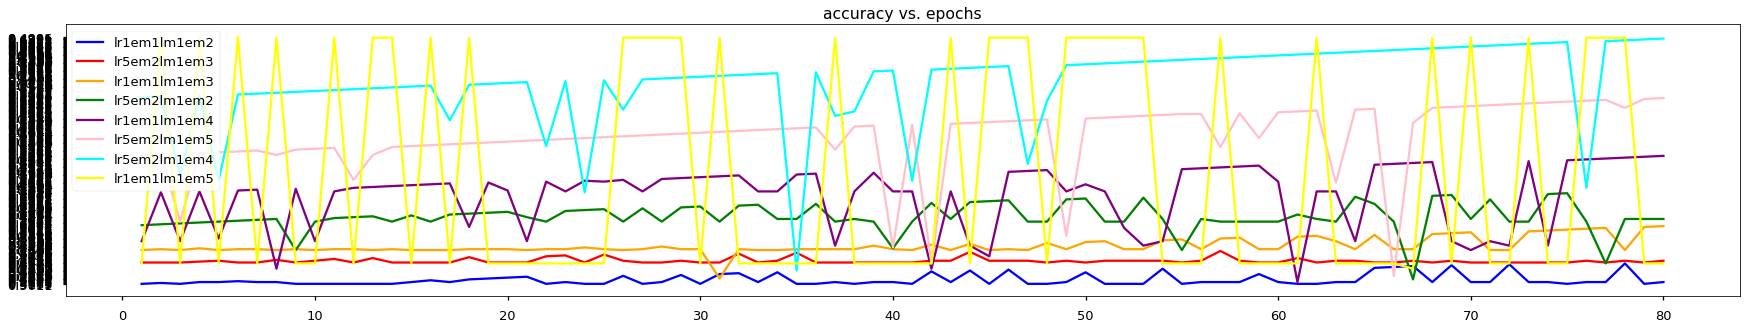

In [53]:
# plt.rcParams['figure.figsize'] = [30, 5]

toEpoch = 80

x_range = int(len(loss_each_batch)*toEpoch/200)
plt.plot(np.arange(x_range)+1, loss_each_batch_lr1em1lm1em2[0:x_range], c='blue')
plt.plot(np.arange(x_range)+1, loss_each_batch_lr1em1lm1em3[0:x_range], c='red')
plt.plot(np.arange(x_range)+1, loss_each_batch_lr1em1lm1em4[0:x_range], c='orange')
plt.plot(np.arange(x_range)+1, loss_each_batch_lr1em1lm1em5[0:x_range], c='green')
plt.plot(np.arange(x_range)+1, loss_each_batch_lr5em2lm1em2[0:x_range], c='purple')
plt.plot(np.arange(x_range)+1, loss_each_batch_lr5em2lm1em3[0:x_range], c='pink')
plt.plot(np.arange(x_range)+1, loss_each_batch_lr5em2lm1em4[0:x_range], c='cyan')
plt.plot(np.arange(x_range)+1, loss_each_batch_lr5em2lm1em5[0:x_range], c='yellow')
# plt.plot(np.arange(len(loss_val_each_batch))+1, loss_val_each_batch)
# plt.legend({'training loss', 'validation loss'})
# plt.xlim(1, len(loss_each_batch))
# plt.ylim(0,max(loss_each_batch))
# plt.axis([1, x_range, 0, 3])
plt.legend({'lr1em1lm1em2','lr1em1lm1em3','lr1em1lm1em4','lr1em1lm1em5','lr5em2lm1em2','lr5em2lm1em3','lr5em2lm1em4','lr5em2lm1em5'})
plt.title('training loss vs. batchs')
plt.show()

# plt.plot(np.arange(len(loss_each_batch))+1, loss_each_batch)
x_range = int(len(loss_val_each_batch)*toEpoch/200)
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr1em1lm1em2[0:x_range], c='blue')
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr1em1lm1em3[0:x_range], c='red')
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr1em1lm1em4[0:x_range], c='orange')
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr1em1lm1em5[0:x_range], c='green')
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr5em2lm1em2[0:x_range], c='purple')
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr5em2lm1em3[0:x_range], c='pink')
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr5em2lm1em4[0:x_range], c='cyan')
plt.plot(np.arange(x_range)+1, loss_val_each_batch_lr5em2lm1em5[0:x_range], c='yellow')
# plt.legend({'training loss', 'validation loss'})
# plt.xlim(1, len(loss_val_each_batch))
# plt.ylim(0, max(loss_val_each_batch))
# plt.axis([1, x_range, 0, 3])
plt.legend({'lr1em1lm1em2','lr1em1lm1em3','lr1em1lm1em4','lr1em1lm1em5','lr5em2lm1em2','lr5em2lm1em3','lr5em2lm1em4','lr5em2lm1em5'})
plt.title('validation loss vs. batchs')
plt.show()

x_range = int(len(acc_each_batch)*toEpoch/200)
plt.plot(np.arange(x_range)+1, acc_each_batch_lr1em1lm1em2[0:x_range], c='blue')
plt.plot(np.arange(x_range)+1, acc_each_batch_lr1em1lm1em3[0:x_range], c='red')
plt.plot(np.arange(x_range)+1, acc_each_batch_lr1em1lm1em4[0:x_range], c='orange')
plt.plot(np.arange(x_range)+1, acc_each_batch_lr1em1lm1em5[0:x_range], c='green')
plt.plot(np.arange(x_range)+1, acc_each_batch_lr5em2lm1em2[0:x_range], c='purple')
plt.plot(np.arange(x_range)+1, acc_each_batch_lr5em2lm1em3[0:x_range], c='pink')
plt.plot(np.arange(x_range)+1, acc_each_batch_lr5em2lm1em4[0:x_range], c='cyan')
plt.plot(np.arange(x_range)+1, acc_each_batch_lr5em2lm1em5[0:x_range], c='yellow')
# plt.xlim([1., len(acc_each_batch)+0.])
# plt.ylim([0.,1.])
# plt.axis([1, len(acc_each_batch), 0, 1])
# plt.axis([1, x_range, 0, 1])
plt.legend({'lr1em1lm1em2','lr1em1lm1em3','lr1em1lm1em4','lr1em1lm1em5','lr5em2lm1em2','lr5em2lm1em3','lr5em2lm1em4','lr5em2lm1em5'})
plt.title('accuracy vs. batchs')
plt.show()

# plt.axis([1, 200, 0, 1])
x_range = int(len(acc_each_epoch)*toEpoch/200)
# plt.axis('auto') 
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr1em1lm1em2[0:x_range], c='blue')
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr1em1lm1em3[0:x_range], c='red')
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr1em1lm1em4[0:x_range], c='orange')
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr1em1lm1em5[0:x_range], c='green')
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr5em2lm1em2[0:x_range], c='purple')
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr5em2lm1em3[0:x_range], c='pink')
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr5em2lm1em4[0:x_range], c='cyan')
plt.plot(np.arange(x_range)+1, acc_each_epoch_lr5em2lm1em5[0:x_range], c='yellow')
plt.legend({'lr1em1lm1em2','lr1em1lm1em3','lr1em1lm1em4','lr1em1lm1em5','lr5em2lm1em2','lr5em2lm1em3','lr5em2lm1em4','lr5em2lm1em5'})
# plt.xlim([1., len(acc_each_epoch)+0.])
# plt.ylim([0.,1.])
# plt.axis([1, x_range, 0, 1])
plt.title('accuracy vs. epochs')
plt.show()



In [58]:
# model = torch.load('./full_dummy_'+file_name+'_model.pt')
# model.load_state_dict(torch.load('./dummy_'+file_name+'_model.pth'))

model = model_lr5em2lm1em4

In [59]:
# Validation process

correct = 0
total = 0
for x_batch, y_batch in test_loader:
    outputs, K, V = model(x_batch)
    _, predicted = torch.max(outputs.data, 1)
    total += y_batch.size(0)
    correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()

print('Validation Accuracy: {}%'.format(100 * int(correct) / total))    


Validation Accuracy: 46.6%


In [60]:
genome_locs = list(np.arange(0,GENOME_LENGTH))
vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}

genome_N_vals = ['N'] * GENOME_LENGTH
genome_A_vals = ['A'] * GENOME_LENGTH
genome_C_vals = ['C'] * GENOME_LENGTH
genome_T_vals = ['T'] * GENOME_LENGTH
genome_G_vals = ['G'] * GENOME_LENGTH

genome_N = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_N_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_A = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_A_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_C = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_C_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_T = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_T_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_G = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_G_vals, genome_locs)], dtype=int)), requires_grad=False)



In [61]:
# for plotting

q_size = model.query_size
# q_size = 1
point_size = 50
alpha_value = 1
width = 30
height = 5

torch.Size([100, 1])
torch.Size([100, 2])
torch.Size([100, 1])


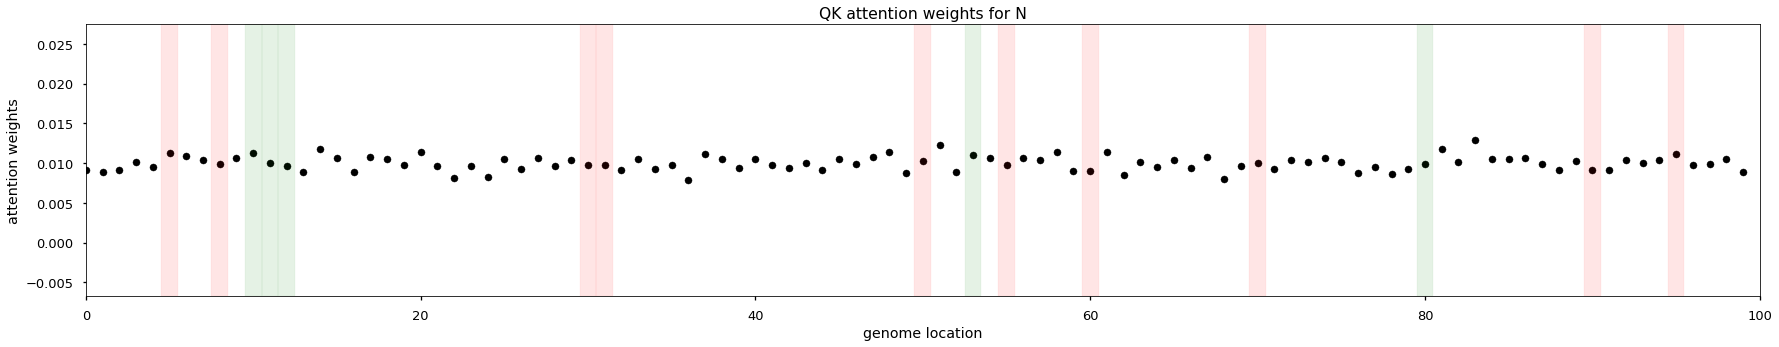

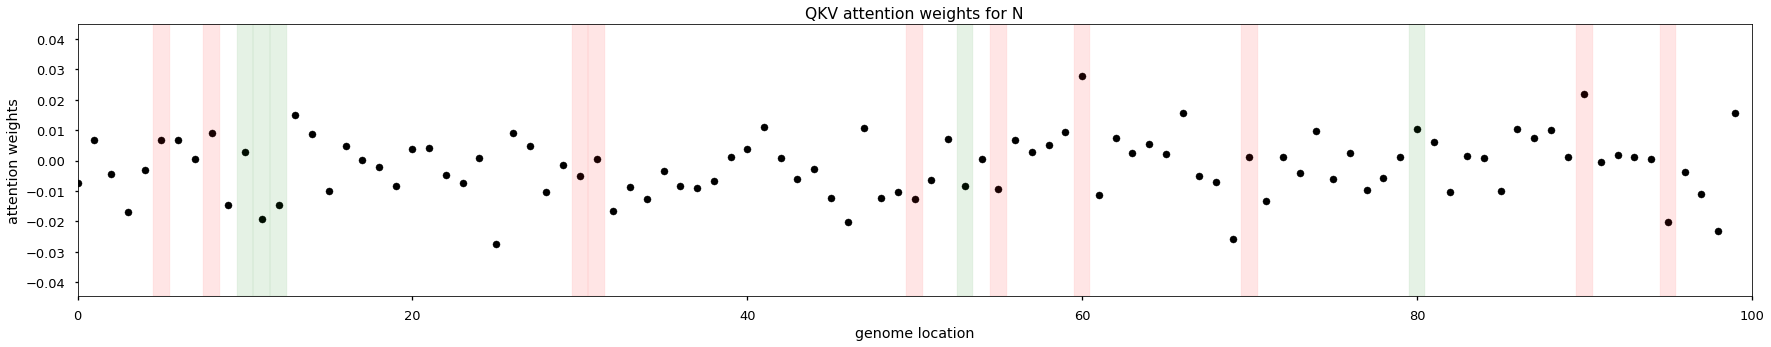

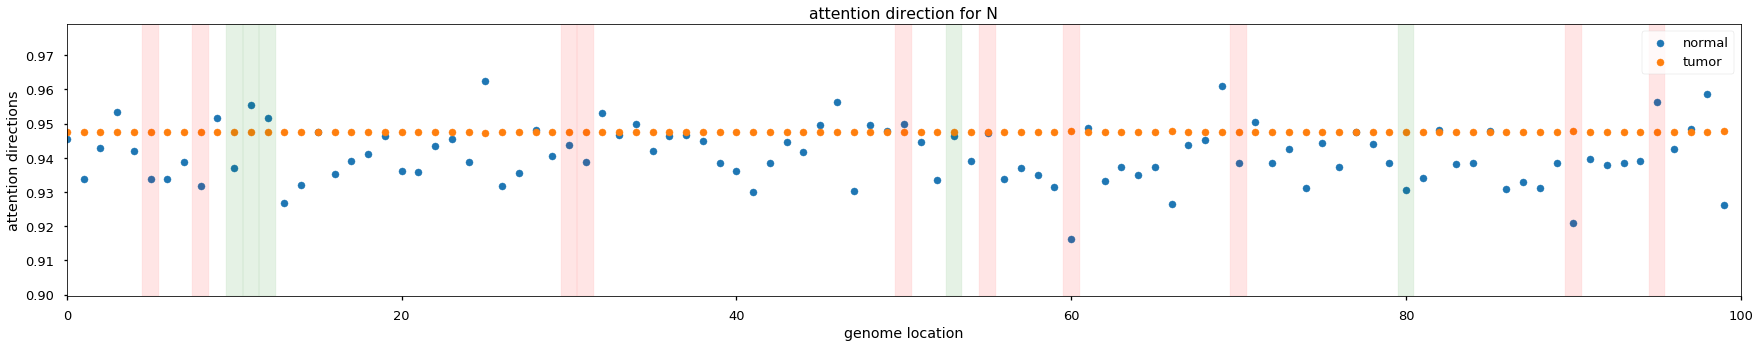

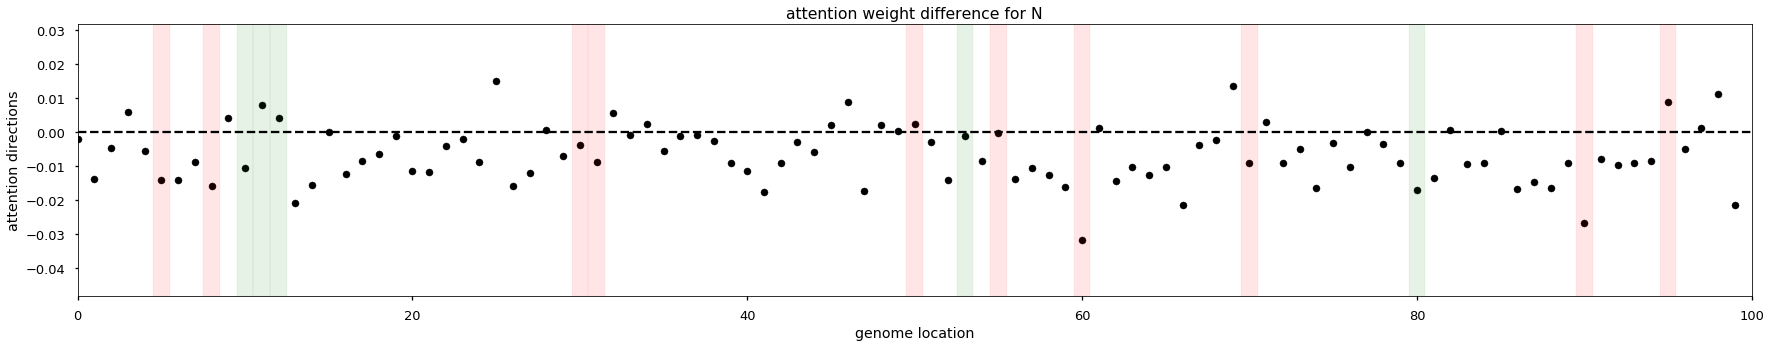

In [62]:
K_lookup_N = model.K(genome_N) 
V_lookup_N = model.V(genome_N) 
logits_N = model.Q(K_lookup_N) / math.sqrt(model.embedding_size)
probs_N = F.softmax(logits_N, dim = 0)    
X_N = probs_N * V_lookup_N
Y_N = model.W(X_N)

print(probs_N.shape)
print(Y_N.shape)
print(logits_N.shape)

# print((torch.norm(K_lookup_N,2,1).mean() + torch.norm(V_lookup_N,2,1).mean())*lam)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QK attention weights for N')
# plt.savefig('./N-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)

plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_N.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for N')
# plt.savefig('./N-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for N')
# plt.savefig('./N-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0]-Y_N.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_N.data[:,0]-Y_N.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for N')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./N-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()


torch.Size([100, 1])
torch.Size([100, 2])


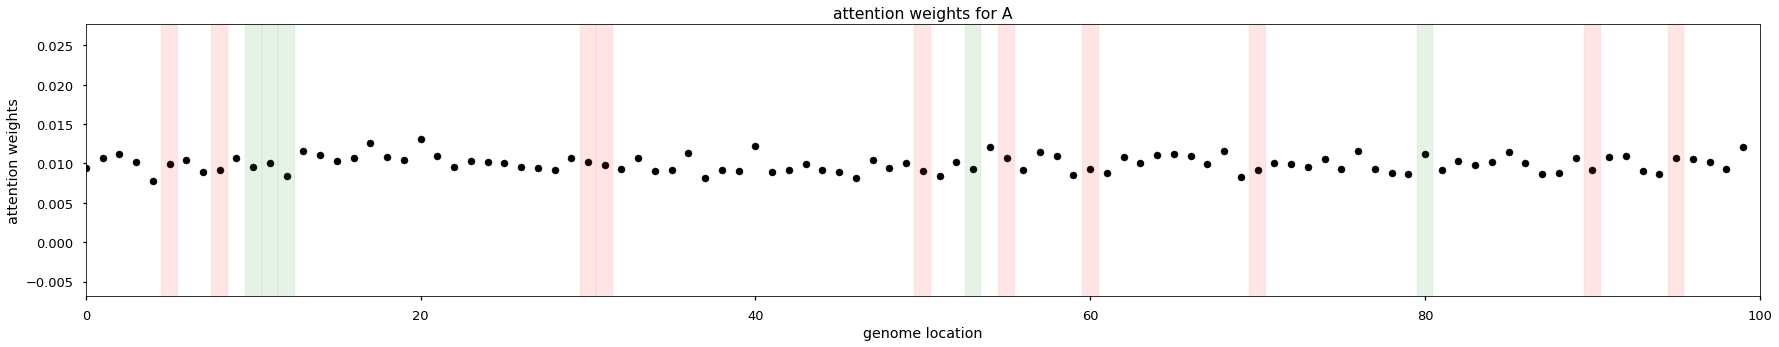

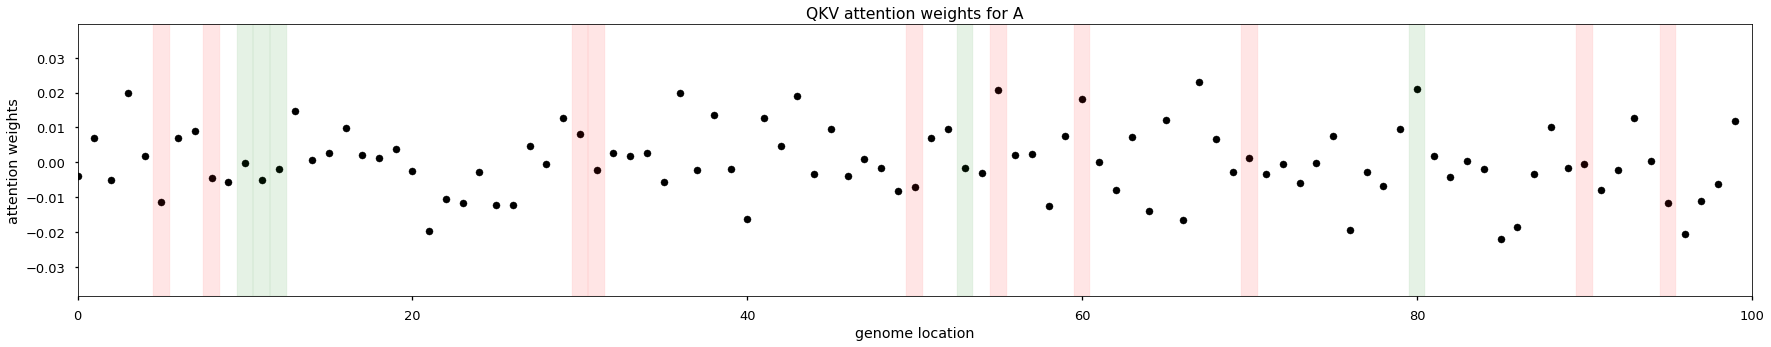

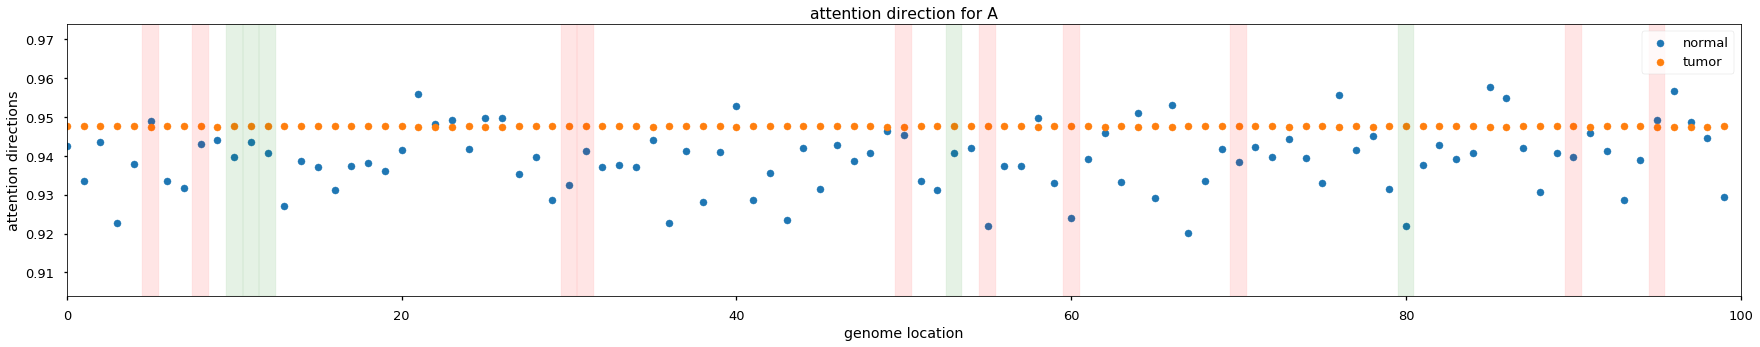

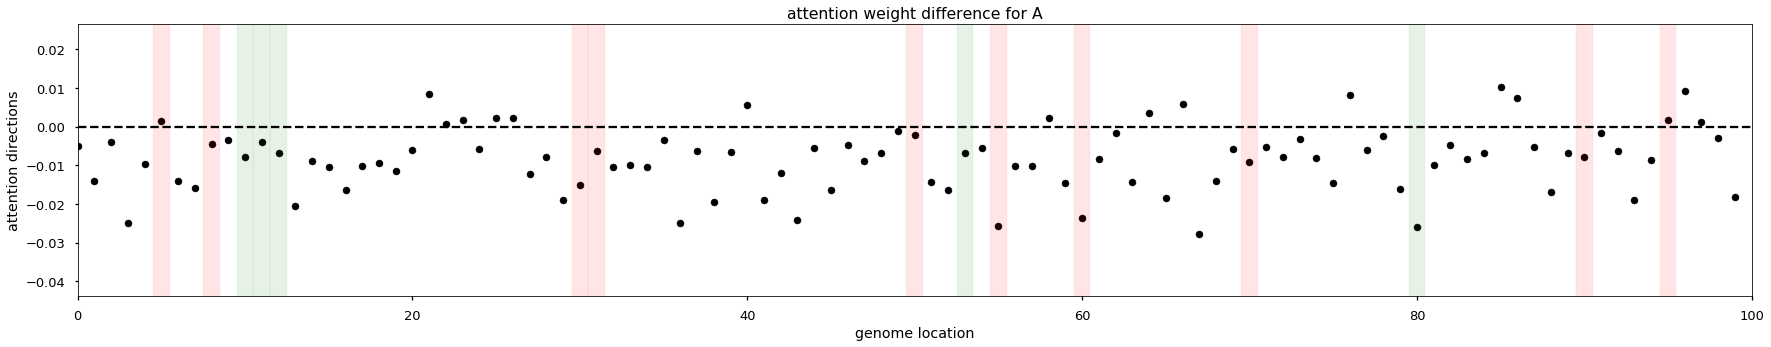

In [63]:
K_lookup_A = model.K(genome_A) 
V_lookup_A = model.V(genome_A) 
logits_A = model.Q(K_lookup_A) / math.sqrt(model.embedding_size)
probs_A = F.softmax(logits_A, dim = 0)    
X_A = probs_A * V_lookup_A
Y_A = model.W(X_A)

print(probs_A.shape)
print(Y_A.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for A')
# plt.savefig('./A-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_A.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for A')
# plt.savefig('./A-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for A')
# plt.savefig('./A-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0]-Y_A.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_A.data[:,0]-Y_A.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for A')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./A-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()



torch.Size([100, 1])
torch.Size([100, 2])


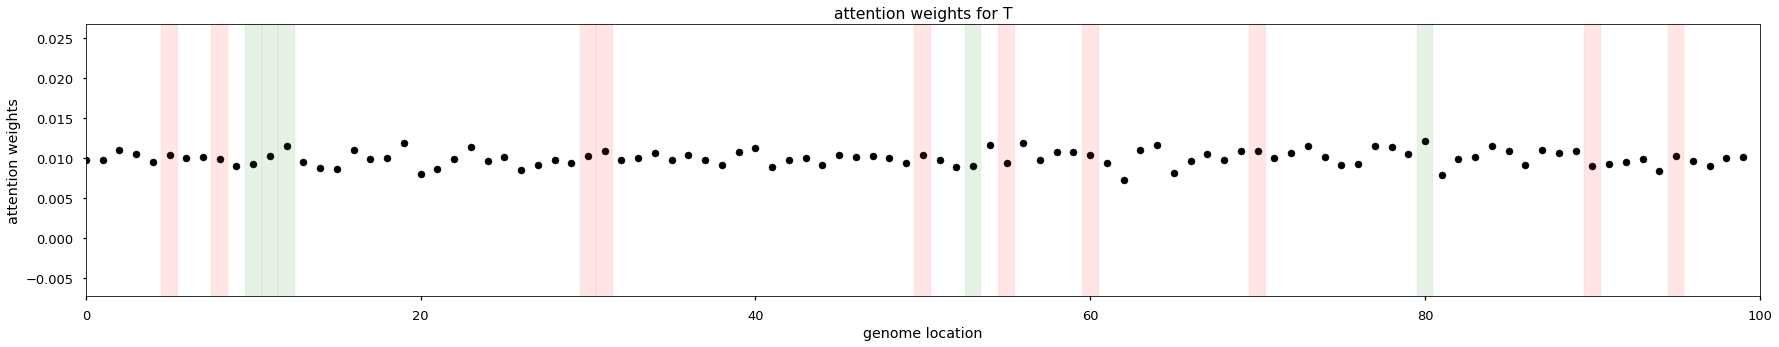

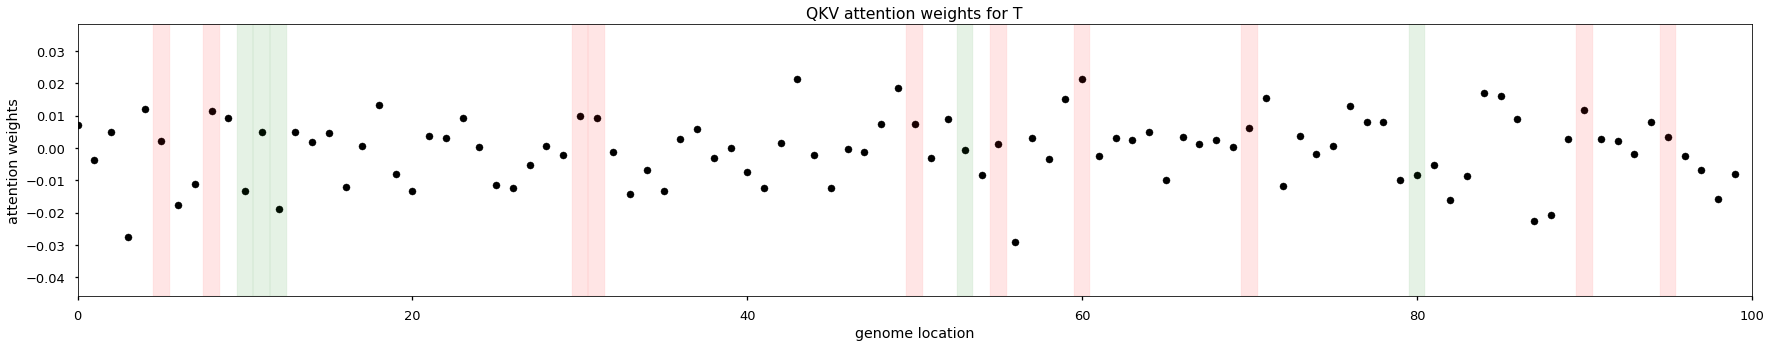

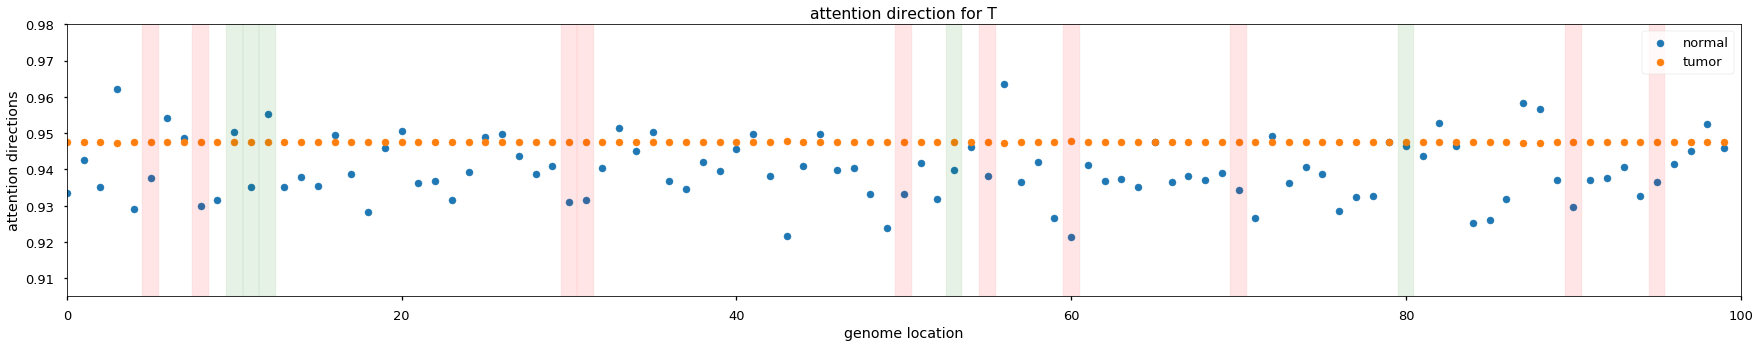

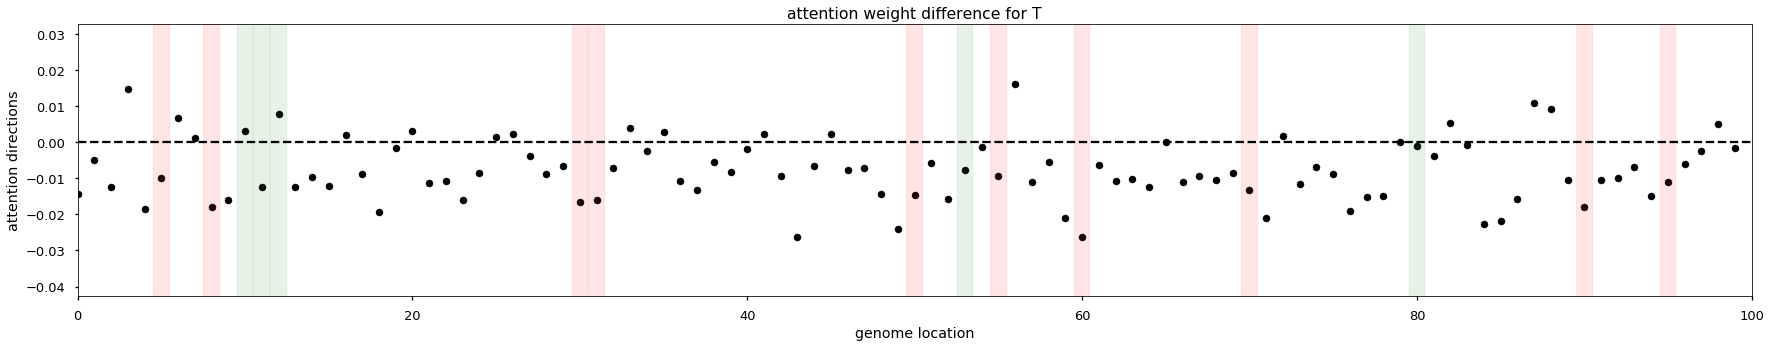

In [64]:
K_lookup_T = model.K(genome_T) 
V_lookup_T = model.V(genome_T) 
logits_T = model.Q(K_lookup_T) / math.sqrt(model.embedding_size)
probs_T = F.softmax(logits_T, dim = 0)    
X_T = probs_T * V_lookup_T
Y_T = model.W(X_T)

print(probs_T.shape)
print(Y_T.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for T')
# plt.savefig('./T-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_T.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for T')
# plt.savefig('./T-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for T')
# plt.savefig('./T-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0]-Y_T.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_T.data[:,0]-Y_T.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for T')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./T-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()


torch.Size([100, 1])
torch.Size([100, 2])


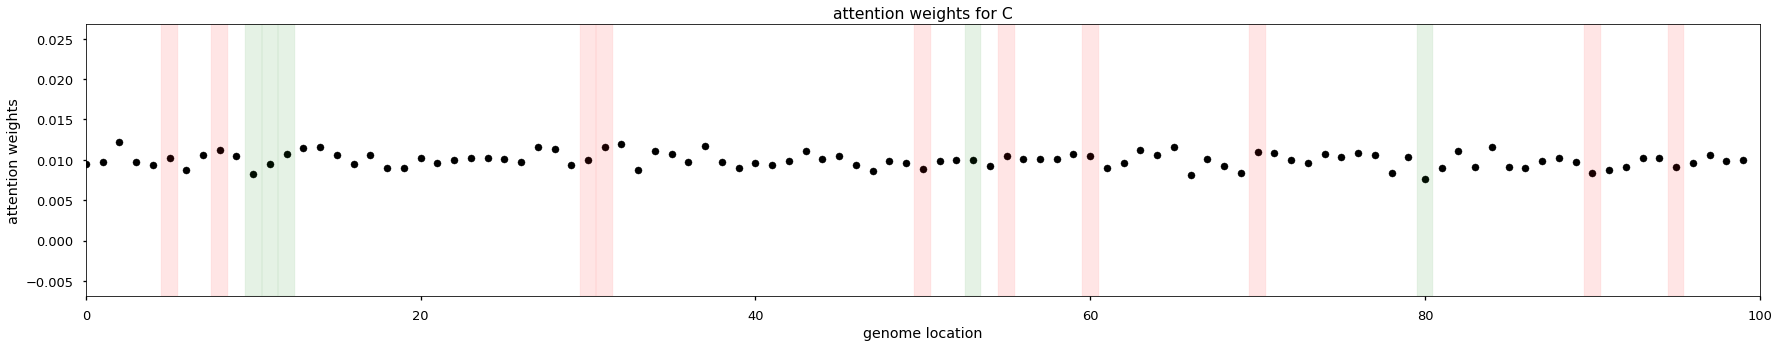

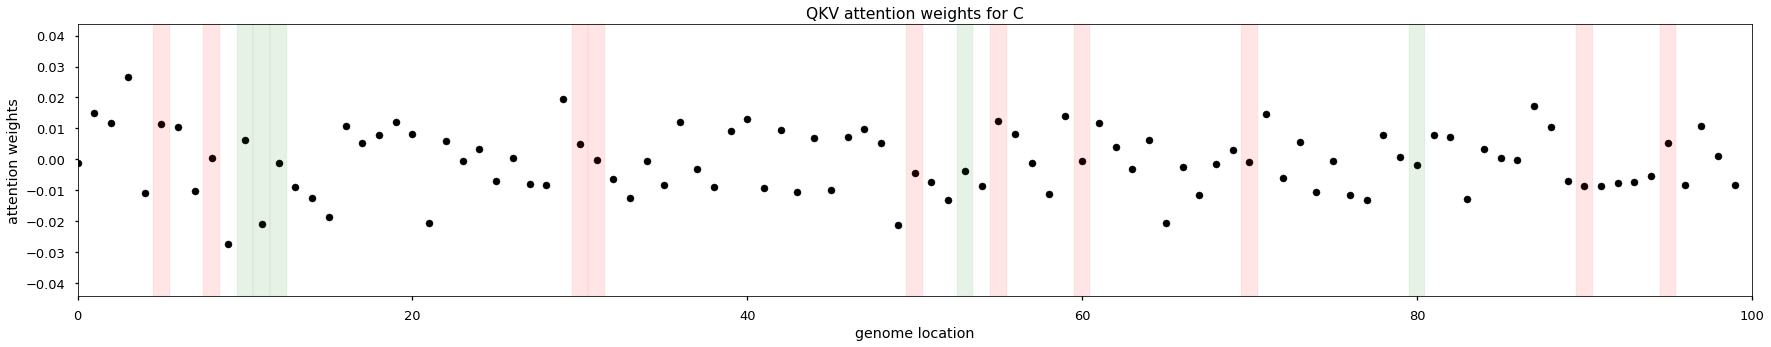

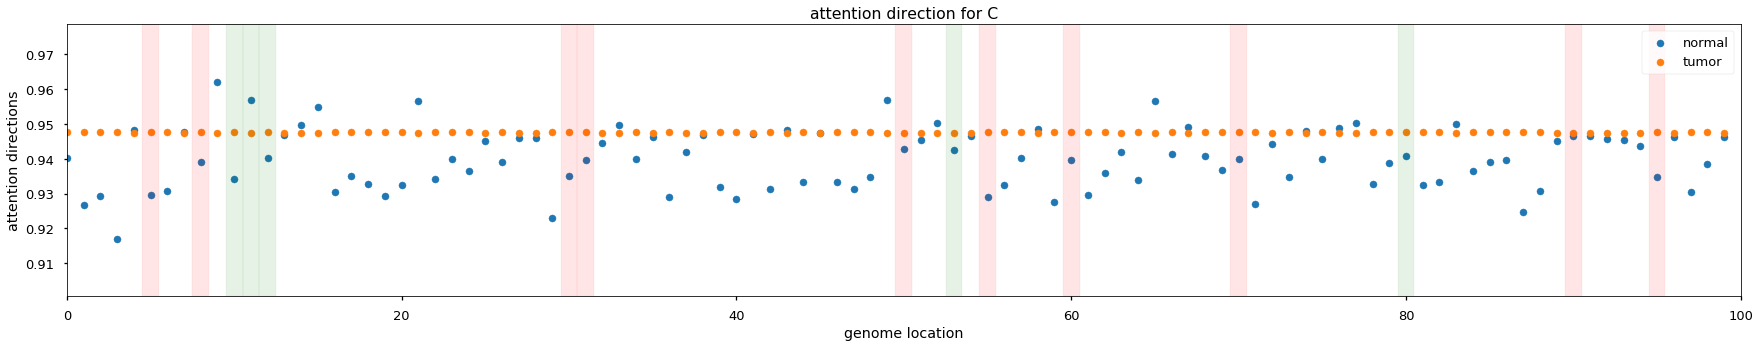

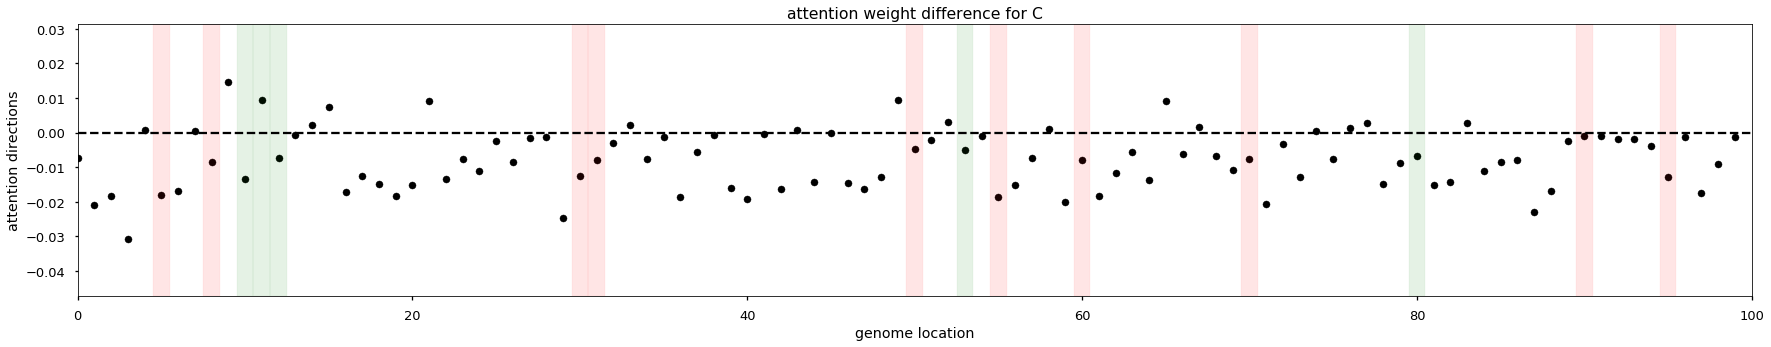

In [65]:
K_lookup_C = model.K(genome_C) 
V_lookup_C = model.V(genome_C) 
logits_C = model.Q(K_lookup_C) / math.sqrt(model.embedding_size)
probs_C = F.softmax(logits_C, dim = 0)    
X_C = probs_C * V_lookup_C
Y_C = model.W(X_C)

print(probs_C.shape)
print(Y_C.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for C')
# plt.savefig('./C-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_C.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for C')
# plt.savefig('./C-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for C')
# plt.savefig('./C-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0]-Y_C.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_C.data[:,0]-Y_C.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for C')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./C-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()


torch.Size([100, 1])
torch.Size([100, 2])


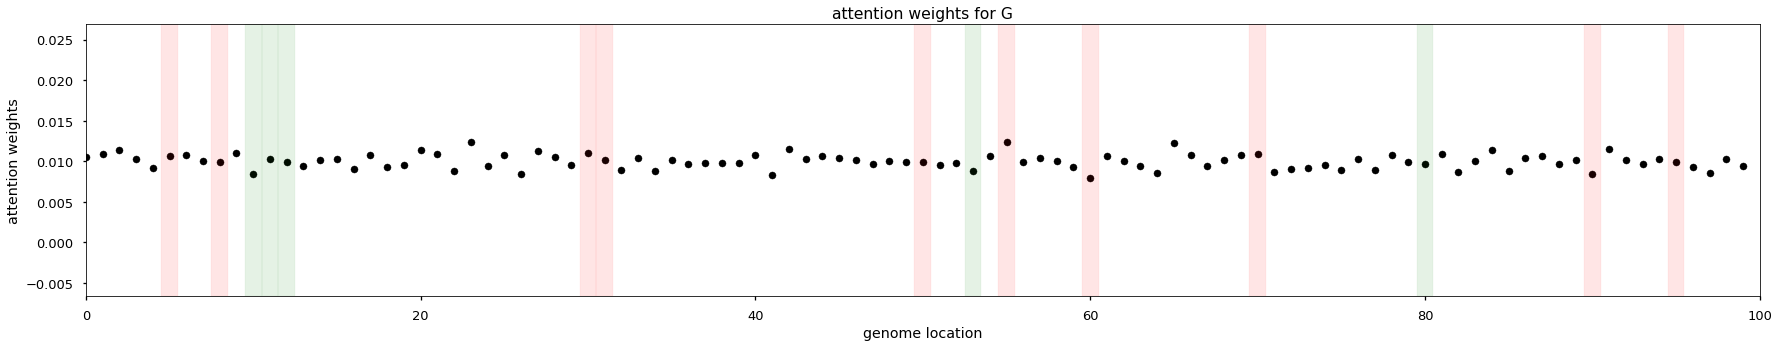

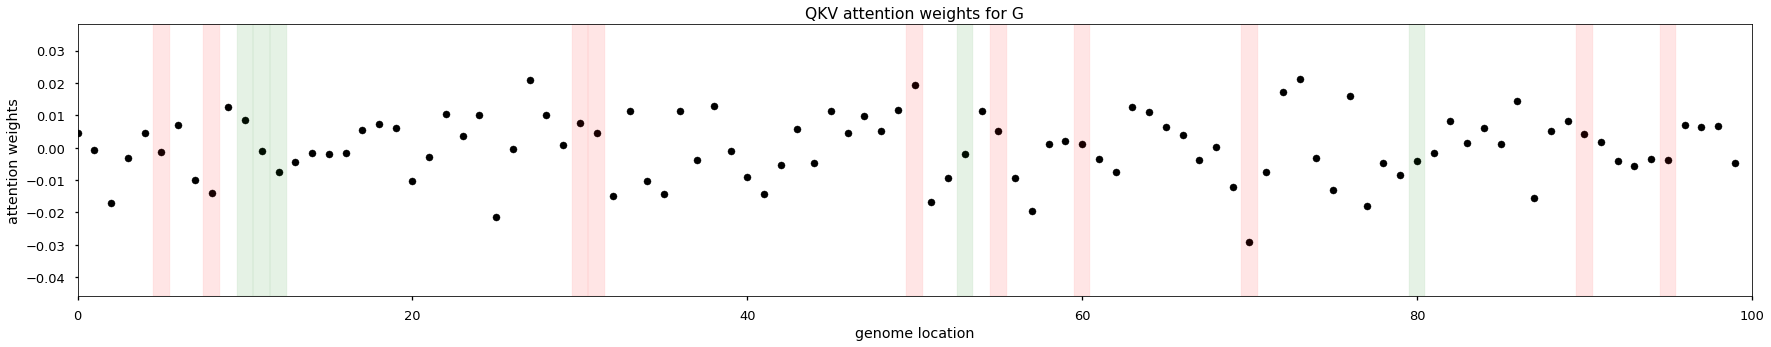

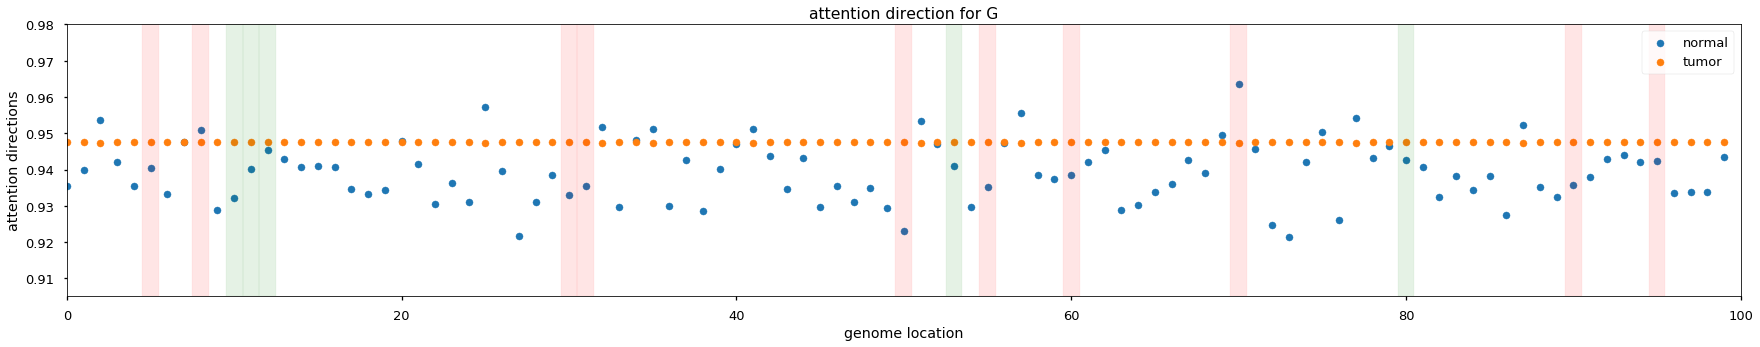

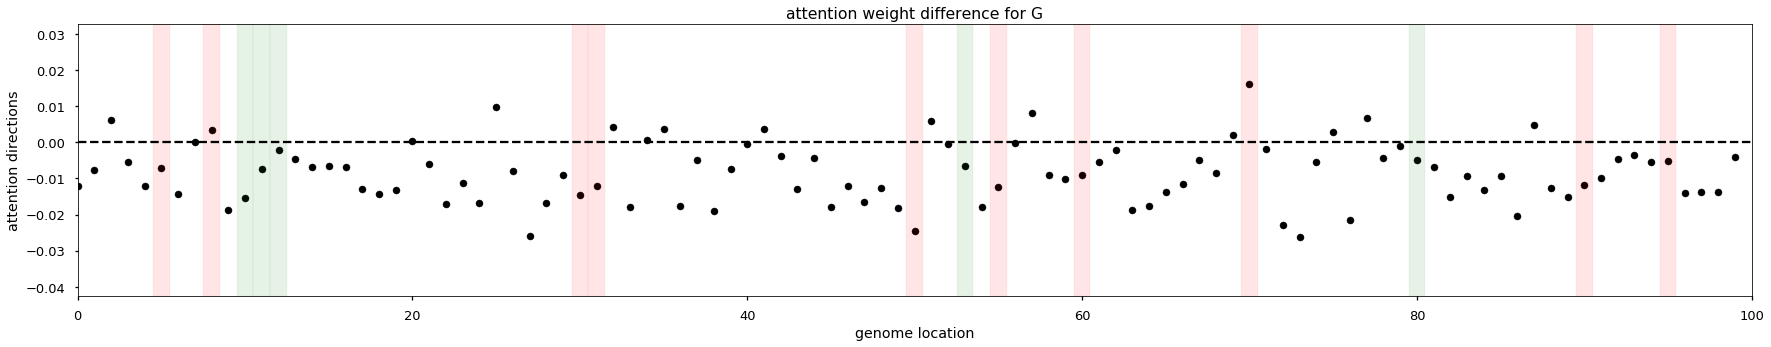

In [66]:
K_lookup_G = model.K(genome_G) 
V_lookup_G = model.V(genome_G) 
logits_G = model.Q(K_lookup_G) / math.sqrt(model.embedding_size)
probs_G = F.softmax(logits_G, dim = 0)    
X_G = probs_G * V_lookup_G
Y_G = model.W(X_G)

print(probs_G.shape)
print(Y_G.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for G')
# plt.savefig('./G-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_G.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for G')
# plt.savefig('./G-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for G')
# plt.savefig('./G-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0]-Y_G.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_G.data[:,0]-Y_G.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for G')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./G-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)

plt.show()


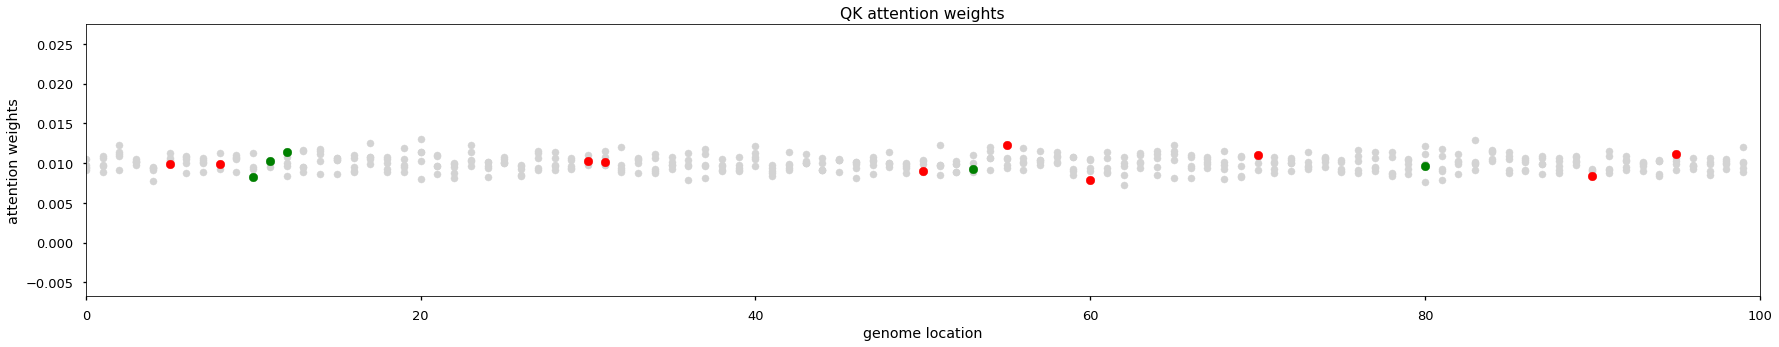

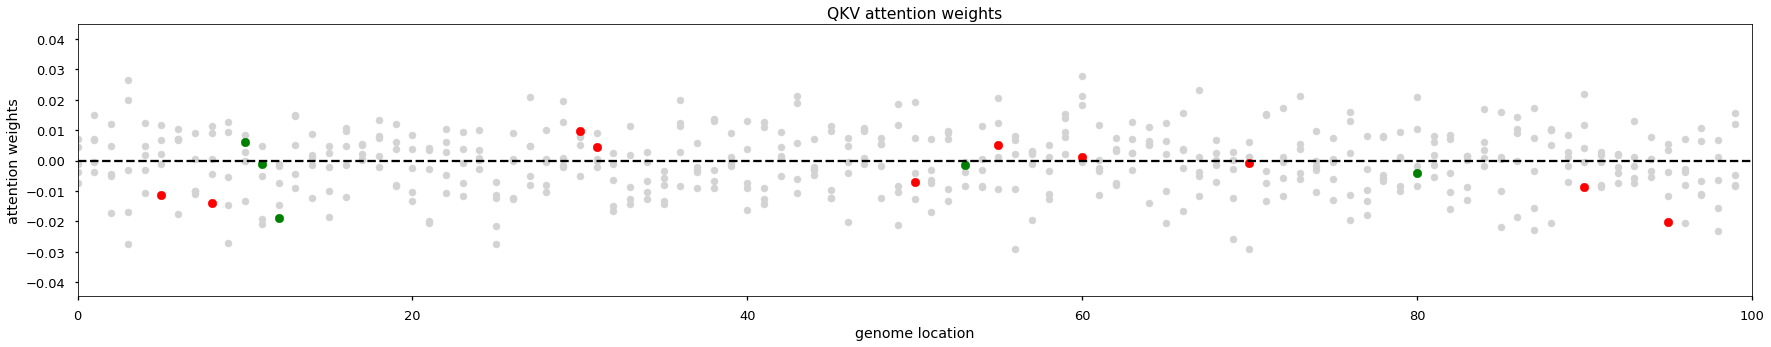

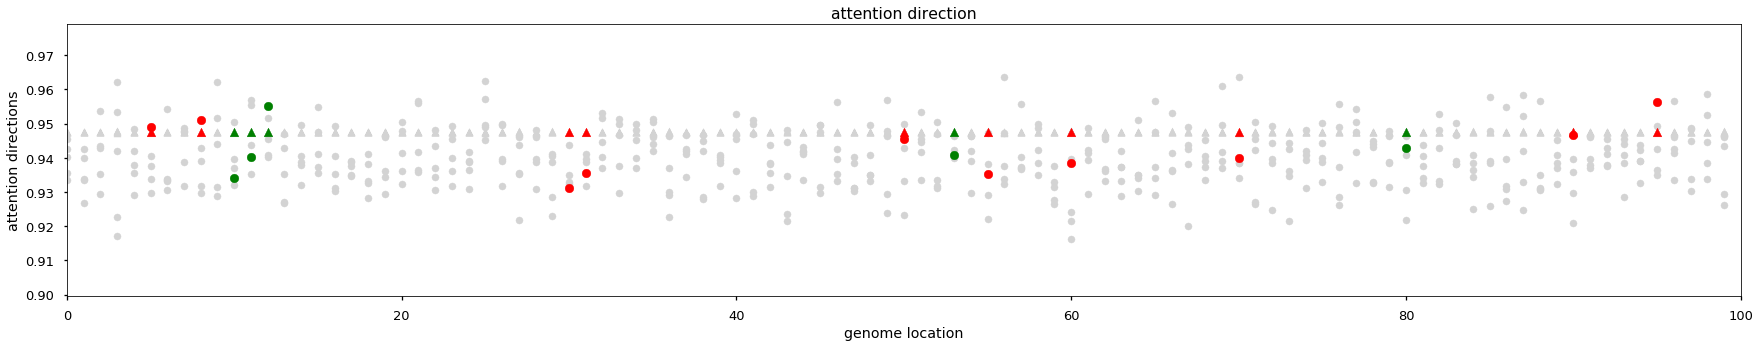

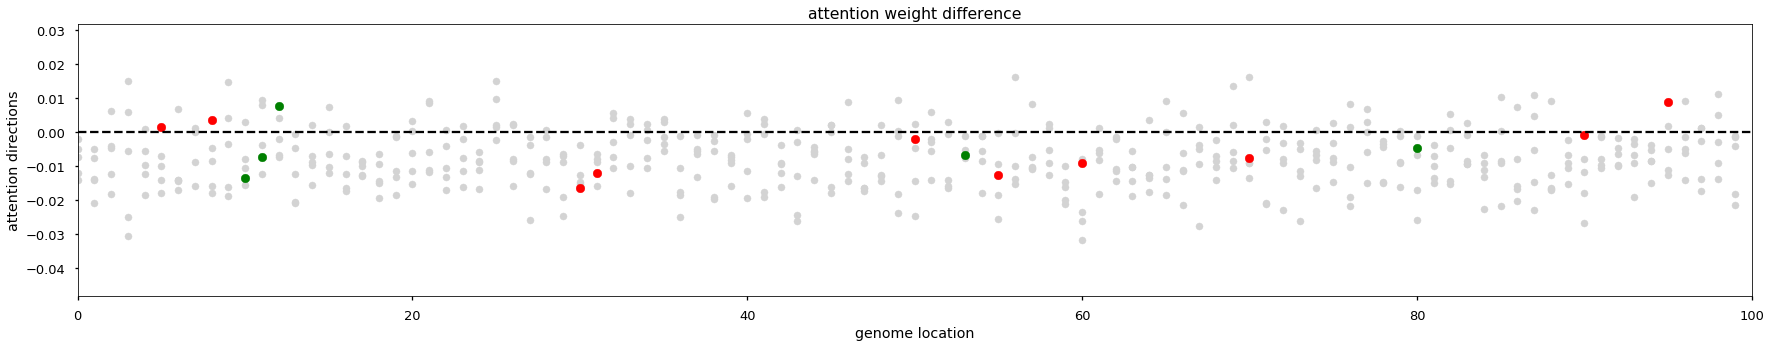

In [68]:
# probs
# X
# Y
# Y_diff

muts = {'N': [probs_N.data, X_N.data, Y_N.data, Y_N.data[:,0]-Y_N.data[:,1]],
        'A': [probs_A.data, X_A.data, Y_A.data, Y_A.data[:,0]-Y_A.data[:,1]],
        'T': [probs_T.data, X_T.data, Y_T.data, Y_T.data[:,0]-Y_T.data[:,1]],
        'C': [probs_C.data, X_C.data, Y_C.data, Y_C.data[:,0]-Y_C.data[:,1]],
        'G': [probs_G.data, X_G.data, Y_G.data, Y_G.data[:,0]-Y_G.data[:,1]]}


for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    
    for loc, value in cancer_genes.items():
        plt.scatter(loc, muts[value[0]][0][loc,q], s=point_size*1.5, alpha=alpha_value, c='red')
    for loc, value in benign_genes.items():
        plt.scatter(loc, muts[value[0]][0][loc,q], s=point_size*1.5, alpha=alpha_value, c='green')
    
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QK attention weights')
# plt.savefig('./attn-'+file_name+'.png')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_N.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_A.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_T.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_C.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_G.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    
    for loc, value in cancer_genes.items():
        plt.scatter(loc, muts[value[0]][1][loc,q], s=point_size*1.5, alpha=alpha_value, c='red')
    for loc, value in benign_genes.items():
        plt.scatter(loc, muts[value[0]][1][loc,q], s=point_size*1.5, alpha=alpha_value, c='green')

plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights')
# plt.savefig('./Vatt-'+file_name+'.png')
plt.axhline(y=0,ls='dashed',c='black')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')

for loc, value in cancer_genes.items():
    plt.scatter(loc, muts[value[0]][2][loc,0], s=point_size*1.5, alpha=alpha_value, marker='o', c='red')
    plt.scatter(loc, muts[value[0]][2][loc,1], s=point_size*1.5, alpha=alpha_value, marker='^', c='red')
for loc, value in benign_genes.items():
    plt.scatter(loc, muts[value[0]][2][loc,0], s=point_size*1.5, alpha=alpha_value, marker='o', c='green')
    plt.scatter(loc, muts[value[0]][2][loc,1], s=point_size*1.5, alpha=alpha_value, marker='^', c='green')

# plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction')
# plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./dirc-'+file_name+'.png')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0]-Y_N.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0]-Y_A.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0]-Y_T.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0]-Y_C.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0]-Y_G.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
for loc, value in cancer_genes.items():
    plt.scatter(loc, muts[value[0]][3][loc], s=point_size*1.5, alpha=alpha_value, c='red')
for loc, value in benign_genes.items():
    plt.scatter(loc, muts[value[0]][3][loc], s=point_size*1.5, alpha=alpha_value, c='green')
    
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./diff-'+file_name+'.png')   
plt.show()


In [100]:
# for x_batch, y_batch in test_loader:
# #     print(x_batch.shape)
# #     print(x_batch[0,:])
# #     print(y_batch)
#     print(y_batch[0:1])
#     optimizer.zero_grad()

#     z = torch.stack((x_batch[0,:],x_batch[0,:]))
# #     outputs, K, V = model(z) 
#     outputs, K, V = model(x_batch[0:1,:]) 
#     data_loss = criterion(outputs, torch.max(y_batch[0:1], 1)[1])